In [308]:
from tqdm import notebook
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os,re
from tqdm.notebook import tqdm,tnrange
from torchvision.transforms import PILToTensor, ToPILImage

from DatasetUtils.PlotUtils import plotResultsWithMasks, plotPairsWithMasks, plotLeafTimeSeries,plotExampleWithMasks
from DatasetUtils.DataParsing import leafDataset, findPairs_for_evaluation
from tracking.timeSeries import createMaskTimeSeries
from modelTraining.modelDefinition import get_instance_segmentation_model
from PIL import ImageDraw
from torchvision.transforms import ToPILImage
from cv2 import findContours, boundingRect, RETR_TREE, CHAIN_APPROX_SIMPLE

from tracking.pairing import *
import time

torch.cuda.get_device_name(0)

In [309]:
start =time.time()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model =get_instance_segmentation_model(2)
stateDict = torch.load("Models/Leaf_Segmentation_MaskedRCNN_7_7_2022_8h.h5",map_location=device)
model.load_state_dict(stateDict)
model.to(device)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

0it [00:00, ?it/s]

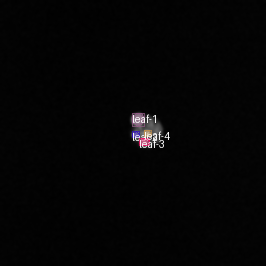

In [ ]:
images = os.listdir(os.path.join(os.getcwd(),"Datasets/Degraded_BrightnessContrast_1"))
test_images = [os.path.join(os.getcwd(),"Datasets/Degraded_BrightnessContrast_1",e) for e in images]
test_json = [os.path.join(os.getcwd(),"Datasets/Mask_rcnn_validation_dataset/","Annotations",re.sub("\.png|\.jpg",".json",e)) for e in images]
testDataset = leafDataset(test_images,test_json)
testDataset.plotExampleWithMasks(np.random.randint(0,len(testDataset)))

In [307]:
from PIL import Image
import numpy as np
import os
from tqdm import tqdm

# Set where to save
pred_dir = os.path.join(os.getcwd(), "Datasets", "Predicted_Masks_Blur7")
os.makedirs(pred_dir, exist_ok=True)

# Save labeled visualizations from testDataset
for i, img_path in tqdm(enumerate(test_images), total=len(test_images)):
    try:
        result = testDataset.plotExampleWithMasks(i)

        base_name = os.path.splitext(os.path.basename(img_path))[0]
        save_path = os.path.join(pred_dir, f"{base_name}_labeled.png")

        if isinstance(result, Image.Image):
            result.save(save_path)
        elif isinstance(result, np.ndarray):
            Image.fromarray(result).save(save_path)
        else:
            print(f"[Skipped] Unsupported return type for {base_name}")
    except Exception as e:
        print(f"[Skipped] {img_path} due to error: {e}")


 51%|█████     | 27/53 [00:00<00:00, 34.27it/s]

[Skipped] c:\Sumitra\Leaf-Tracking\Datasets/Degraded_Blur_5x5\Late_94_8.png due to error: coordinate list must contain at least 2 coordinates


100%|██████████| 53/53 [00:01<00:00, 36.63it/s]


In [291]:
if device.type == "cuda":
    results = []
    for i in tqdm(testDataset):
        i = torch.reshape(i[0],shape=(1,1,266,266))
        i = i.cuda()
        this_result = model(i)
        for idx,result in enumerate(this_result):
            for k,v in result.items():
                result[k] = v.detach().cpu()
            this_result[idx] = result
        results.append(this_result)
        del result
        del v
        del this_result
        del i
        torch.cuda.empty_cache()
else:
    results = []
    for i in tqdm(testDataset):
        this_result=model(i[0])
        results.append(this_result)

100%|██████████| 53/53 [00:04<00:00, 10.60it/s]


In [293]:
for i in range(len(testDataset)):
    testDataset[i][1]["Category"] = re.sub(".*\\\\|_.*","",testDataset.ids_dict[i])

groundTruth = [e[1] for e in testDataset]
filtered_results = []
for e in results:
    temp_results = {
        "boxes":[],
        "labels":[],
        "scores":[],
        "masks":[]
    }
    for idx,val in enumerate(e[0]["scores"]):
        if val < 0.9:
            continue
        else:
            temp_results["boxes"].append(e[0]["boxes"][idx])
            temp_results["labels"].append(e[0]["labels"][idx])
            temp_results["scores"].append(e[0]["scores"][idx])
            temp_results["masks"].append(e[0]["masks"][idx][0])
    temp_results["boxes"] = torch.stack(temp_results["boxes"])
    temp_results["labels"] = torch.stack(temp_results["labels"])
    temp_results["scores"] = torch.stack(temp_results["scores"])
    temp_results["masks"] = torch.stack(temp_results["masks"])
    filtered_results.append(temp_results)

filtered_results

[{'boxes': tensor([[142.3758, 125.0332, 149.5663, 131.2304]]),
  'labels': tensor([1]),
  'scores': tensor([0.9558]),
  'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]])},
 {'boxes': tensor([[137.9532, 108.7768, 150.5750, 122.4192],
          [143.7144, 134.7826, 156.7452, 148.5490],
          [149.3111, 120.2114, 159.6886, 129.6147],
          [134.2428, 123.2953, 145.4749, 133.6188]]),
  'labels': tensor([1, 1, 1, 1]),
  'scores': tensor([0.9891, 0.9806, 0.9752, 0.9489]),
  'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
 

In [294]:
all_pairs = []
all_notDetected = []
all_missDetection = []
for i in tnrange(len(groundTruth)):
    all_data = findPairs_for_evaluation(groundTruth[i],filtered_results[i])
    all_pairs.append(all_data[0])
    all_notDetected.append(all_data[1])
    all_missDetection.append(all_data[2])

  0%|          | 0/53 [00:00<?, ?it/s]

In [295]:
early = []
mid = []
late = []
for e in all_pairs:
    for j in e:
        if j["type"] == "Early":
            early.append(j["IoU"])
        elif j["type"] == "Late":
            late.append(j["IoU"])
        else:
            mid.append(j["IoU"])


In [296]:
df = pd.DataFrame([early,mid,late]).transpose()
df.columns = ["Early","Mid","Late"]
df.describe()

,Early,Mid,Late
count,43.000000,119.000000,207.000000
mean,0.727033,0.879717,0.771619
std,0.094024,0.082681,0.211179
min,0.430769,0.237537,0.176114
25%,0.687135,0.879063,0.707944
50%,0.736842,0.900854,0.874669
75%,0.781136,0.918188,0.915108
max,0.891892,0.951220,0.952825


In [298]:
earlyNotDetectedCounter = 0
midNotDetectedCounter = 0
lateNotDetectedCounter = 0
for i in all_notDetected:
    if len(i)> 0:
        if i[0]["type"] == "Early":
            earlyNotDetectedCounter += len(i)
        elif i[0]["type"] == "Late":
            lateNotDetectedCounter += len(i)
        else:
            midNotDetectedCounter += len(i)
print("""
Leafs not detected:
Early stage: {}
Mid stage: {}
Late stage: {}""".format(earlyNotDetectedCounter,midNotDetectedCounter,lateNotDetectedCounter))
earlymissDetectedCounter = 0
midmissDetectedCounter = 0
latemissDetectedCounter = 0
for i in all_missDetection:
    if len(i) > 0:
        if i[0]["type"] == "Early":
            earlymissDetectedCounter += len(i)
        elif i[0]["type"] == "Late":
            latemissDetectedCounter += len(i)
        else:
            midmissDetectedCounter += len(i)
print("""
Leafs errounisly detected:
Early stage: {}
Mid stage: {}
Late stage: {}""".format(earlymissDetectedCounter, midmissDetectedCounter, latemissDetectedCounter))

earlyPairs = 0
midPairs = 0
latePairs = 0
for i in all_pairs:
    if len(i) > 0:
        if i[0]["type"] == "Early":
            earlyPairs += len(i)
        elif i[0]["type"] == "Late":
            latePairs += len(i)
        else:
            midPairs += len(i)
print("""
Leafs correctly detected:
Early stage: {}
Mid stage: {}
Late stage: {}""".format(earlyPairs, midPairs, latePairs))


Leafs not detected:
Early stage: 25
Mid stage: 32
Late stage: 97

Leafs errounisly detected:
Early stage: 1
Mid stage: 1
Late stage: 13

Leafs correctly detected:
Early stage: 43
Mid stage: 119
Late stage: 207


In [299]:
f1df = pd.DataFrame([[earlyPairs,midPairs,latePairs],
                    [earlyNotDetectedCounter,midNotDetectedCounter,lateNotDetectedCounter],
                    [earlymissDetectedCounter,midmissDetectedCounter,latemissDetectedCounter]]).transpose()
f1df.columns = ["Correct","FalseNegative","FalsePositive"]
f1df.index = ["Early","Mid","Late"]
f1df["Precision"] = f1df["Correct"]/(f1df["Correct"]+f1df["FalsePositive"])
f1df["Recall"] = f1df["Correct"]/(f1df["Correct"]+f1df["FalseNegative"])
f1df["F-score"] = (f1df["Precision"]*f1df["Recall"])/(f1df["Precision"]+f1df["Recall"])*2
f1df.to_excel("PrecisionAndRecall.xlsx")

In [300]:
df.to_excel("IoU_raw_values.xlsx")
df.describe().to_excel("IoU_statistics.xlsx")